In [3]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [4]:
x_2=inputs[1]
d_in=inputs.shape[1]
d_out=2


In [5]:
torch.manual_seed(123)
w_query=torch.nn.Parameter(torch.randn(d_in,d_out),requires_grad=False)
w_key=torch.nn.Parameter(torch.randn(d_in,d_out),requires_grad=False)
w_value=torch.nn.Parameter(torch.randn(d_in,d_out),requires_grad=False) 


In [6]:
print("Query:",w_query)


Query: Parameter containing:
tensor([[-0.1115,  0.1204],
        [-0.3696, -0.2404],
        [-1.1969,  0.2093]])


test with the indivisual word


In [7]:
query_2=x_2 @ w_query
key_2=x_2 @ w_key
value_2=x_2 @ w_value
print(query_2)
print(key_2)
print(value_2)

tensor([-1.1729, -0.0048])
tensor([-0.1142, -0.7676])
tensor([0.4107, 0.6274])


Let's do this with the Whole Input


In [8]:
query=inputs @ w_query
keys=inputs @ w_key
values= inputs @ w_value

print(query)

tensor([[-1.1686,  0.2019],
        [-1.1729, -0.0048],
        [-1.1438, -0.0018],
        [-0.6339, -0.0439],
        [-0.2979,  0.0535],
        [-0.9596, -0.0712]])


In [9]:
keys_2=keys[1]
attn_Score=query_2 @ keys_2
print(attn_Score) 

tensor(0.1376)


In [10]:

attn_Score=query @ keys.T
print(attn_Score) 

tensor([[ 0.0740, -0.0216,  0.0126, -0.1230,  0.6250, -0.4498],
        [ 0.2172,  0.1376,  0.1730, -0.0491,  0.7616, -0.3809],
        [ 0.2098,  0.1320,  0.1665, -0.0489,  0.7408, -0.3725],
        [ 0.1458,  0.1061,  0.1254, -0.0118,  0.4384, -0.1919],
        [ 0.0175, -0.0071,  0.0017, -0.0321,  0.1580, -0.1153],
        [ 0.2240,  0.1642,  0.1935, -0.0161,  0.6667, -0.2888]])


In [11]:
normalized_attn_Score=torch.nn.functional.softmax(attn_Score,dim=1)
print(normalized_attn_Score)

tensor([[0.1667, 0.1515, 0.1568, 0.1369, 0.2893, 0.0988],
        [0.1689, 0.1560, 0.1616, 0.1294, 0.2912, 0.0929],
        [0.1691, 0.1564, 0.1619, 0.1305, 0.2876, 0.0945],
        [0.1710, 0.1643, 0.1675, 0.1461, 0.2291, 0.1220],
        [0.1684, 0.1643, 0.1658, 0.1603, 0.1938, 0.1475],
        [0.1708, 0.1609, 0.1657, 0.1344, 0.2659, 0.1023]])


In [12]:
d_k=keys.shape[-1]
attn_weights_2=torch.nn.functional.softmax(attn_Score/d_k**2,dim=1)
print(attn_weights_2)

tensor([[0.1684, 0.1644, 0.1658, 0.1603, 0.1933, 0.1477],
        [0.1692, 0.1658, 0.1673, 0.1583, 0.1938, 0.1457],
        [0.1691, 0.1658, 0.1673, 0.1585, 0.1931, 0.1462],
        [0.1683, 0.1666, 0.1675, 0.1618, 0.1811, 0.1547],
        [0.1672, 0.1662, 0.1665, 0.1651, 0.1732, 0.1617],
        [0.1690, 0.1665, 0.1677, 0.1592, 0.1888, 0.1487]])


Calculating the Context Vector

In [13]:
context_vector=attn_weights_2 @ values
print(context_vector)

tensor([[0.2861, 0.3929],
        [0.2865, 0.3933],
        [0.2865, 0.3931],
        [0.2867, 0.3901],
        [0.2867, 0.3880],
        [0.2867, 0.3921]])


We will Create a class implementation of the Self Attention machanism with trainable weights


In [14]:
import torch.nn as nn

class SelfAttensionMachanism_v1(nn.Module):
    def __init__(self,d_in,d_out):
        super().__init__()
        self.w_query=nn.Parameter(torch.randn(d_in,d_out))
        self.w_key=nn.Parameter(torch.randn(d_in,d_out))
        self.w_value=nn.Parameter(torch.randn(d_in,d_out))


    def forward(self,inputs):
        keys=inputs @ self.w_key
        query=inputs @ self.w_query
        values=inputs @ self.w_value

        attn_score=query @ keys.T
        attn_weights=torch.nn.functional.softmax(attn_score/keys.shape[-1]**0.5,dim=-1)

        context_vector=attn_weights @ values
        return context_vector    

In [15]:
Am_v1=SelfAttensionMachanism_v1(d_in,d_out)
context_vector=Am_v1(inputs)
print(context_vector)

tensor([[0.1278, 0.2577],
        [0.1365, 0.2556],
        [0.1364, 0.2556],
        [0.1294, 0.2624],
        [0.1295, 0.2595],
        [0.1310, 0.2618]], grad_fn=<MmBackward0>)


In [16]:
import torch.nn as nn

class SelfAttensionMachanism_v2(nn.Module):
    def __init__(self,d_in,d_out,qkv_bias=False):
        super().__init__()
        self.w_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_value=nn.Linear(d_in,d_out, bias=qkv_bias)


    def forward(self,inputs):
        keys=self.w_key(inputs)
        query=self.w_query(inputs)
        values=self.w_value(inputs)

        attn_score=query @ keys.T
        attn_weights=torch.nn.functional.softmax(attn_score/keys.shape[-1]**0.5,dim=-1)

        context_vector=attn_weights @ values
        return context_vector    

In [17]:
Am_v2=SelfAttensionMachanism_v2(d_in,d_out)
context_vector=Am_v2(inputs)
print(context_vector)

tensor([[-0.4496,  0.4982],
        [-0.4462,  0.4957],
        [-0.4462,  0.4956],
        [-0.4478,  0.4971],
        [-0.4468,  0.4963],
        [-0.4479,  0.4971]], grad_fn=<MmBackward0>)


Causal Self Attention Machanism


In [18]:
queries=Am_v2.w_query(inputs)
key=Am_v2.w_key(inputs)

attention_score=queries @ key.T

attention_weight=torch.nn.functional.softmax(attention_score/key.shape[-1]**0.5,dim=-1)
print(attention_weight)

tensor([[0.1708, 0.1646, 0.1647, 0.1665, 0.1681, 0.1654],
        [0.1723, 0.1579, 0.1587, 0.1690, 0.1818, 0.1603],
        [0.1722, 0.1579, 0.1587, 0.1690, 0.1819, 0.1603],
        [0.1696, 0.1616, 0.1621, 0.1681, 0.1755, 0.1630],
        [0.1703, 0.1596, 0.1603, 0.1688, 0.1796, 0.1615],
        [0.1701, 0.1617, 0.1622, 0.1680, 0.1750, 0.1631]],
       grad_fn=<SoftmaxBackward0>)


In [19]:
context_length=attention_weight.shape[0]
simple_mask=torch.tril(torch.ones(context_length,context_length))
print(simple_mask)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [20]:
masked_simple = attention_weight * simple_mask
print(masked_simple)

tensor([[0.1708, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1723, 0.1579, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1722, 0.1579, 0.1587, 0.0000, 0.0000, 0.0000],
        [0.1696, 0.1616, 0.1621, 0.1681, 0.0000, 0.0000],
        [0.1703, 0.1596, 0.1603, 0.1688, 0.1796, 0.0000],
        [0.1701, 0.1617, 0.1622, 0.1680, 0.1750, 0.1631]],
       grad_fn=<MulBackward0>)


In [21]:
rows_sum=masked_simple.sum(dim=1,keepdim=True)
masked_attention_weights=masked_simple/rows_sum
print(masked_attention_weights)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5217, 0.4783, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3524, 0.3230, 0.3246, 0.0000, 0.0000, 0.0000],
        [0.2564, 0.2443, 0.2450, 0.2542, 0.0000, 0.0000],
        [0.2031, 0.1904, 0.1911, 0.2013, 0.2141, 0.0000],
        [0.1701, 0.1617, 0.1622, 0.1680, 0.1750, 0.1631]],
       grad_fn=<DivBackward0>)


In [22]:
mask=torch.triu(torch.ones(context_length,context_length),diagonal=1)
masked = attention_weight.masked_fill(mask.bool(),-torch.inf)
print(masked)

tensor([[0.1708,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1723, 0.1579,   -inf,   -inf,   -inf,   -inf],
        [0.1722, 0.1579, 0.1587,   -inf,   -inf,   -inf],
        [0.1696, 0.1616, 0.1621, 0.1681,   -inf,   -inf],
        [0.1703, 0.1596, 0.1603, 0.1688, 0.1796,   -inf],
        [0.1701, 0.1617, 0.1622, 0.1680, 0.1750, 0.1631]],
       grad_fn=<MaskedFillBackward0>)


In [23]:
attention_weight=torch.nn.functional.softmax(masked/key.shape[-1]**0.5,dim=-1)
print(attention_weight)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5025, 0.4975, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3355, 0.3321, 0.3323, 0.0000, 0.0000, 0.0000],
        [0.2508, 0.2493, 0.2494, 0.2505, 0.0000, 0.0000],
        [0.2004, 0.1989, 0.1989, 0.2002, 0.2017, 0.0000],
        [0.1671, 0.1661, 0.1661, 0.1668, 0.1676, 0.1662]],
       grad_fn=<SoftmaxBackward0>)


In [24]:
torch.manual_seed(123)
dropout=torch.nn.Dropout(p=0.5)
example=torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [25]:

print(dropout(attention_weight))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6647, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4987, 0.0000, 0.5010, 0.0000, 0.0000],
        [0.0000, 0.3977, 0.3979, 0.4003, 0.4034, 0.0000],
        [0.3341, 0.3322, 0.0000, 0.0000, 0.3353, 0.3325]],
       grad_fn=<MulBackward0>)


In [26]:
import torch.nn as nn
class CausalSelfAttention(nn.Module):
    def __init__(self,d_in,d_out,qkv_bias=False):
        super().__init__()
        self.w_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.dropout=torch.nn.Dropout(p=0.1)

    def forward(self,inputs):
        keys=self.w_key(inputs)
        query=self.w_query(inputs)
        values=self.w_value(inputs)

        attention_score=query @ keys.T
        attention_weight=torch.nn.functional.softmax(attention_score/key.shape[-1]**0.5,dim=-1)
        context_length=attention_weight.shape[0]
        simple_mask=torch.tril(torch.ones(context_length,context_length))
        masked_simple = attention_weight * simple_mask
        rows_sum=masked_simple.sum(dim=1,keepdim=True)
        masked_attention_weights=masked_simple/rows_sum
        masked_attention_weights*=values
        mask=torch.triu(torch.ones(context_length,context_length),diagonal=1)
        masked = attention_weight.masked_fill(mask.bool(),-torch.inf)
        attention_weight=torch.nn.functional.softmax(masked/key.shape[-1]**0.5,dim=-1)
        
        

        return self.dropout(attention_weight)

In [27]:
Am_v2=CausalSelfAttention(3,6)
context_vector=Am_v2(inputs)
print(context_vector)

tensor([[1.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5600, 0.5511, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3742, 0.3682, 0.3687, 0.0000, 0.0000, 0.0000],
        [0.2781, 0.2762, 0.2764, 0.2805, 0.0000, 0.0000],
        [0.2229, 0.2194, 0.2196, 0.2229, 0.0000, 0.0000],
        [0.0000, 0.1832, 0.1833, 0.1870, 0.1882, 0.1852]],
       grad_fn=<MulBackward0>)


In [28]:
batch=torch.stack((inputs,inputs,inputs,inputs,inputs,inputs,inputs,inputs),dim=0)
print(batch.shape)

torch.Size([8, 6, 3])


Causal Self Attention with the batch sizes

In [29]:
import torch.nn as nn
class CausalSelfAttention_v2(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,qkv_bias=False):
        super().__init__()
        self.w_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.dropout=torch.nn.Dropout(p=dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))
    
    def forward(self,inputs):
        b,num_tokens,d_in=inputs.shape      
        keys=self.w_key(inputs)
        query=self.w_query(inputs)
        values=self.w_value(inputs)

        attention_score=query @ keys.transpose(1,2)
        attn_Score.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens].bool(),-torch.inf)
        
        attention_weight=torch.nn.functional.softmax(attention_score/key.shape[-1]**0.5,dim=-1)
        attention_weight=self.dropout(attention_weight)
        context_vector=attention_weight @values
        return context_vector

In [30]:
torch.manual_seed(123)
context_length=batch.shape[1]
ca=CausalSelfAttention_v2(d_in,d_out,context_length,0.0)
context_vector=ca(batch)
print(context_vector)

tensor([[[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
    

Multihead attention Machanism


In [31]:
class MultiheadAttensionMachanism(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bais=False):
        super().__init__()
        self.heads=nn.ModuleList([
             CausalSelfAttention_v2(d_in,d_out,context_length,dropout,qkv_bais )
             for _ in range(num_heads)
        ])

    def forward(self,x ):
        return torch.cat([head(x) for head in self.heads],dim=-1)    

In [32]:
torch.manual_seed(123)
m1=MultiheadAttensionMachanism(d_in,d_out,context_length,0.1,3,False)
context_vector=m1(batch)
print(context_vector)

tensor([[[-0.5191, -0.0904,  0.5650,  0.3897,  0.4649,  0.2185],
         [-0.5915, -0.1200,  0.4928,  0.3737,  0.5907,  0.2765],
         [-0.5915, -0.1199,  0.4938,  0.3240,  0.5176,  0.2352],
         [-0.3656, -0.0533,  0.5638,  0.3856,  0.5933,  0.2779],
         [-0.4538, -0.0808,  0.4739,  0.3267,  0.4188,  0.2054],
         [-0.5888, -0.1201,  0.5641,  0.3882,  0.5037,  0.2243]],

        [[-0.5930, -0.1168,  0.4707,  0.3309,  0.5913,  0.2768],
         [-0.5915, -0.1200,  0.5649,  0.3898,  0.3950,  0.1895],
         [-0.5233, -0.0920,  0.5649,  0.3896,  0.5907,  0.2765],
         [-0.5886, -0.1195,  0.5638,  0.3856,  0.5933,  0.2779],
         [-0.4538, -0.0808,  0.3526,  0.2706,  0.5923,  0.2775],
         [-0.5888, -0.1201,  0.5641,  0.3882,  0.4634,  0.2187]],

        [[-0.5930, -0.1168,  0.5650,  0.3897,  0.4988,  0.2215],
         [-0.5915, -0.1200,  0.5649,  0.3898,  0.4654,  0.2187],
         [-0.5233, -0.0920,  0.4708,  0.3309,  0.5907,  0.2765],
         [-0.4182, -0

Implementing Multihead Attention with Weight Split

In [33]:
class MultiheadAttensionMachanism_v2(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bais=False):
        super().__init__()
        assert( d_out%num_heads==0),\
            "d_out must be Divisible by numeber of Heads"
        self.d_out=d_out
        self.d_in=d_in
        self.num_head=num_heads
        self.head_dim=d_out//num_heads
        self.w_query=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.w_key=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.w_value=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)

        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))


    def forward(self,x):
        b,num_tokens,d_in=x.shape

        keys=self.w_key(x)
        queries=self.w_query(x)
        value=self.w_value(x)

        keys=keys.view(b,num_tokens,self.num_head,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_head,self.head_dim)
        values=value.view(b,num_tokens,self.num_head,self.head_dim)

        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)

        attn_scores=queries @ keys.transpose(2,3)
        
        mask_bool=self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores=masked_fill_(mask_bool,-torch.inf)

        attn_weights=torch.softmax(attn_scores/key.shape[-1]**0.5,dim=-1)
        attn_weights=self.dropout(attn_weights)

        context_vec=(attn_weights @ value).transpose(1,2)

        context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec=self.out_proj(context_vec)

        return context_vec

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [35]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


In [36]:
class MultiheadAttensionMachanism_v2(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bais=False):
        super().__init__()
        assert( d_out%num_heads==0),\
            "d_out must be Divisible by numeber of Heads"
        self.d_out=d_out
        self.d_in=d_in
        self.num_head=num_heads
        self.head_dim=d_out//num_heads
        self.w_query=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.w_key=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.w_value=nn.Linear(d_in,d_out,bias=qkv_bais)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)

        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))


    def forward(self,x):
        b,num_tokens,d_in=x.shape

        keys=self.w_key(x)
        queries=self.w_query(x)
        value=self.w_value(x)

        keys=keys.view(b,num_tokens,self.num_head,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_head,self.head_dim)
        values=value.view(b,num_tokens,self.num_head,self.head_dim)

        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)

        attn_scores=queries @ keys.transpose(2,3)
        
        mask_bool=self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores=masked_fill_(mask_bool,-torch.inf)

        attn_weights=torch.softmax(attn_scores/key.shape[-1]**0.5,dim=-1)
        attn_weights=self.dropout(attn_weights)

        context_vec=(attn_weights @ value).transpose(1,2)

        context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec=self.out_proj(context_vec)

        return context_vec

LLM Architecture Block


In [37]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

Dummy GPT Model

In [38]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

Step 1: Tokenize All the text

In [39]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Step 2: Apply the Layer Normalization on the inputs

In [40]:
torch.manual_seed(123)
batch_example=torch.randn(2,5)
layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out=layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [41]:
mean=out.mean(dim=-1,keepdim=True)
var=out.var(dim=-1,keepdim=True)
print("Mean of the Inputs is:\n",mean)
print("Variance of the inputs is:\n",var)

Mean of the Inputs is:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance of the inputs is:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [42]:
out_norm=(out-mean)/torch.sqrt(var)
mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)
print("Normalized Values:\n",out_norm)
print("Mean of Normalized values:\n",mean)
print("Variance of Normalized Values:\n",var)


Normalized Values:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean of Normalized values:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance of Normalized Values:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [43]:
torch.set_printoptions(sci_mode=False)


print("Normalized Values:\n",out_norm)
print("Mean of Normalized values:\n",mean)
print("Variance of Normalized Values:\n",var)


Normalized Values:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean of Normalized values:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance of Normalized Values:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Making the class of this code


In [44]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var  = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [45]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


GELU Activation Function

In [46]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [47]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [48]:
print(GPT_CONFIG_124M["emb_dim"])


768


In [49]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


ShortCut Connection

In [50]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [51]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [52]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)

In [53]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [54]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


In [55]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


In [56]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [57]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x) 
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [58]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Entire GPT Model

In [59]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        ) 

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [60]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.4708,  0.5737, -0.5967,  ...,  0.2019, -0.5665,  0.1800],
         [-0.3895, -0.1978, -0.8885,  ...,  0.2242, -1.2341,  0.1752],
         [ 0.6973, -0.3432, -0.6080,  ...,  0.3747, -0.6967,  0.1088],
         [-0.2962, -0.6957, -1.1371,  ...,  0.3579,  0.3058, -0.2915]],

        [[-0.1514,  0.3329, -0.9740,  ..., -0.1368, -0.6974, -0.1851],
         [-0.4894, -0.3492, -0.9759,  ...,  0.2951, -0.3396,  0.2109],
         [ 0.5082, -0.1425,  0.2549,  ...,  0.1618,  0.1304, -0.3092],
         [-0.4146, -0.0514, -0.5187,  ..., -0.1869, -0.1303, -0.4969]]],
       grad_fn=<UnsafeViewBackward0>)


Total Number Of Trainable Parameters

In [61]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [62]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [63]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 123,822,336


Memory Requirement for this Model

In [64]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.58 MB


Generating The New Word

In [65]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [66]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [67]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991]])
Output length: 10


In [68]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Laur inhab DistrinetalkQueue


WE haven't Trained the Model Yet, Becuase of Which it will produce the Dummy or False Answers

In [69]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [70]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [71]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [72]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [73]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [74]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [75]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [76]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [77]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [78]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [79]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [80]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Now Let's Use the Real Dataset so We will be using a book data


In [81]:
import os
import urllib.request

file_path = "the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [82]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Create a Data Loaders 

In [83]:
from torch.utils.data import Dataset, DataLoader
import torch

In [84]:
class GPTversion1(Dataset):
    def __init__(self,text#text file to be read
                 ,tokenizer #byte pair tokenizer
                 ,max_length #cotext size
                 ,stride):
        self.input_ids=[]
        self.target_ids=[]
        
        token_ids=tokenizer.encode(text,allowed_special={'<|endoftext|>'})

        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk=token_ids[i:i+max_length]
            target_chunk=token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))


    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,i):
        return self.input_ids[i],self.target_ids[i]

In [85]:
#create Dataset loader
def create_dataset_Loader_V1(text,batch_size=4#number of CPU cores to use
                         ,max_length=256,
                         stride=128,
                         shuffle=True,
                         drop_last=True,
                         num_workers=0#number of CPU threads that we can use simultaneously
                         ):
    #initialize the tokenizer
    tokenizer=tiktoken.get_encoding("gpt2")
    dataset=GPTversion1(text,tokenizer,max_length,stride)
    dataLoader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    return dataLoader





In [86]:
# Train/validation ratio
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataset_Loader_V1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataset_Loader_V1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [87]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [88]:
print(total_tokens * (train_ratio))

4630.5


In [89]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [90]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [91]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [92]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [93]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")  
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)

print("Validation loss:", val_loss)


Training loss: 10.98758347829183
Validation loss: 10.98110580444336


In [94]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen



Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch
    


In [95]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [96]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [97]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

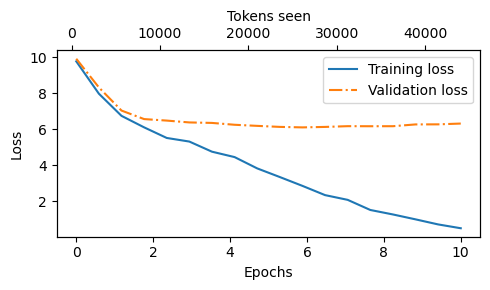

In [98]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [99]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [100]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Temperature Scalling


In [101]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

In [102]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [103]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [104]:

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [105]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [106]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

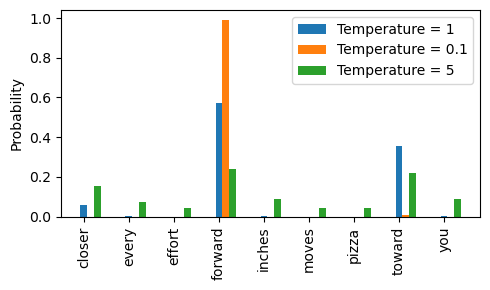

In [107]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

Top-K Sampling

In [108]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [109]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough
